In [1]:
import numpy as np
import pandas as pd
import pmdarima
import seaborn as sns
import statsmodels.api as sm

from arch import arch_model
from scipy import interpolate
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
price_df = pd.read_csv('data/raw/Housing_SalePrice_US.csv')
price_df.head()

,DATE,MSPUS
0,1963-01-01,17800.0
1,1963-04-01,18000.0
2,1963-07-01,17900.0
3,1963-10-01,18500.0
4,1964-01-01,18500.0


In [3]:
# Datetime objects are easier to work with

print(price_df.info())

price_df['DATE'] = pd.to_datetime(price_df['DATE'], format='%Y-%m-%d')

# After
price_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237 entries, 0 to 236
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    237 non-null    object 
 1   MSPUS   237 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.8+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237 entries, 0 to 236
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    237 non-null    datetime64[ns]
 1   MSPUS   237 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.8 KB


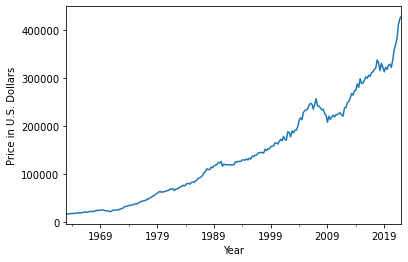

In [4]:
price_df.plot.line('DATE', 'MSPUS', 
                   ylabel='Price in U.S. Dollars',
                   xlabel='Year',
                   legend=False)

plt.savefig('figures/MSPUS_pandas.png', bbox_inches='tight')
plt.show()

In [5]:
macro_df = pd.read_csv('data/raw/Macroecon_US.csv')

# Get the Date column in to a format strftime can handle
macro_df['Date'] = macro_df['Date'].astype('str') + '.01'  # Assume data is from the first of each month
macro_df['Date'] = macro_df['Date'].str.replace('.', '-')
print(macro_df.head())

# Convert to datetime object
macro_df['Date'] = pd.to_datetime(macro_df['Date'], format='%Y.%m')

macro_df.head()

         Date  S&P Comp.  Dividend  Earnings    Consumer Price Index CPI  \
0  1871-01-01       4.44      0.26       0.4                       12.46   
1  1871-02-01       4.50      0.26       0.4                       12.84   
2  1871-03-01       4.61      0.26       0.4                       13.03   
3  1871-04-01       4.74      0.26       0.4                       12.56   
4  1871-05-01       4.86      0.26       0.4                       12.27   

   Date Fraction    Long Interest Rate GS10  Real Price  Real Dividend  \
0          1871.04                     5.32      103.43           6.06   
1          1871.13                     5.32      101.72           5.88   
2          1871.21                     5.33      102.68           5.79   
3          1871.29                     5.33      109.58           6.01   
4          1871.38                     5.33      114.97           6.15   

   Real Total Return Price   ...  Excess CAPE Yield  \
0                   103.43   ...           

/tmp/ipykernel_29859/2529911229.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  macro_df['Date'] = macro_df['Date'].str.replace('.', '-')


,Date,S&P Comp.,Dividend,Earnings,Consumer Price Index CPI,Date Fraction,Long Interest Rate GS10,Real Price,Real Dividend,Real Total Return Price,...,Excess CAPE Yield,Monthly Total Bond Returns,Real Total Bond Returns,10 Year Annualized Stock Real Return,10 Year Annualized Bonds Real Return,Real 10 Year Excess Annualized Returns,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
0,1871-01-01,4.44,0.26,0.4,12.46,1871.04,5.32,103.43,6.06,103.43,...,NaN,1.0,1.00,13.06%,9.25%,3.81%,NaN,NaN,NaN,NaN
1,1871-02-01,4.50,0.26,0.4,12.84,1871.13,5.32,101.72,5.88,102.21,...,NaN,1.0,0.97,13.09%,9.46%,3.62%,NaN,NaN,NaN,NaN
2,1871-03-01,4.61,0.26,0.4,13.03,1871.21,5.33,102.68,5.79,103.66,...,NaN,1.0,0.96,13.10%,9.62%,3.48%,NaN,NaN,NaN,NaN
3,1871-04-01,4.74,0.26,0.4,12.56,1871.29,5.33,109.58,6.01,111.13,...,NaN,1.0,1.00,12.21%,9.10%,3.11%,NaN,NaN,NaN,NaN
4,1871-05-01,4.86,0.26,0.4,12.27,1871.38,5.33,114.97,6.15,117.11,...,NaN,1.0,1.03,12.26%,8.95%,3.31%,NaN,NaN,NaN,NaN


In [6]:
supply_df = pd.read_csv('data/raw/Monthly_Supply_New_Houses_US.csv')

supply_df['DATE'] = pd.to_datetime(supply_df['DATE'], format='%Y-%m-%d')

supply_df.head()

,DATE,MSACSR
0,1963-01-01,4.7
1,1963-02-01,6.6
2,1963-03-01,6.4
3,1963-04-01,5.3
4,1963-05-01,5.1


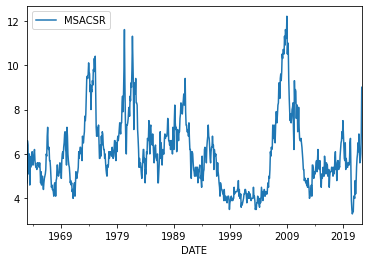

In [7]:
supply_df.plot.line('DATE', 'MSACSR')

plt.savefig('figures/MSACSR_pandas.png')
plt.show()

In [8]:
econ_df = pd.read_csv('data/raw/Macroecon_US.csv')

# Clean col names
econ_df.columns = econ_df.columns.str.strip()

# Remove extraneous columns
econ_df = econ_df.drop(['Date Fraction'], axis=1)  # Date Fraction contains no extra information
econ_df = econ_df.loc[:, ~econ_df.columns.str.contains('^Unnamed')]  # Drop unnamed cols

# Convert object columns to float
non_numeric_cols = econ_df.select_dtypes(include='object').columns
# Commas and % need to be removed for float conversion
econ_df[non_numeric_cols] = econ_df[non_numeric_cols].apply(
                                lambda x: x.str.replace(',|%', '',regex=True).astype(float)
                            )


print(econ_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1817 entries, 0 to 1816
Data columns (total 19 columns):
 #   Column                                                                     Non-Null Count  Dtype  
---  ------                                                                     --------------  -----  
 0   Date                                                                       1817 non-null   float64
 1   S&P Comp.                                                                  1817 non-null   float64
 2   Dividend                                                                   1815 non-null   float64
 3   Earnings                                                                   1812 non-null   float64
 4   Consumer Price Index CPI                                                   1817 non-null   float64
 5   Long Interest Rate GS10                                                    1817 non-null   float64
 6   Real Price                                              

In [9]:
## Convert econ data Dates from object to pd.datetime

# Rename date column to be consistent with other dataframes
econ_df = econ_df.rename(columns={'Date': 'DATE'})

# Get the date column in to a format strftime can handle
econ_df['DATE'] = econ_df['DATE'].apply(lambda x: "{:.2f}".format(x))  # convert to str, keep trailing zeros
econ_df['DATE'] = econ_df['DATE'] + '.01'  # Assume data is from the first of each month
econ_df['DATE'] = econ_df['DATE'].str.replace('.', '-', regex=False)

# Convert to datetime object
econ_df['DATE'] = pd.to_datetime(econ_df['DATE'], format='%Y-%m-%d')

econ_df.head(12)

,DATE,S&P Comp.,Dividend,Earnings,Consumer Price Index CPI,Long Interest Rate GS10,Real Price,Real Dividend,Real Total Return Price,Real Earnings,Real TR Scaled Earnings,Cyclically Adjusted Price Earnings Ratio P/E10 or CAPE,Cyclically Adjusted Total Return Price Earnings Ratio TR P/E10 or TR CAPE,Excess CAPE Yield,Monthly Total Bond Returns,Real Total Bond Returns,10 Year Annualized Stock Real Return,10 Year Annualized Bonds Real Return,Real 10 Year Excess Annualized Returns
0,1871-01-01,4.44,0.26,0.4,12.46,5.32,103.43,6.06,103.43,9.32,9.32,NaN,NaN,NaN,1.0,1.00,13.06,9.25,3.81
1,1871-02-01,4.50,0.26,0.4,12.84,5.32,101.72,5.88,102.21,9.04,9.09,NaN,NaN,NaN,1.0,0.97,13.09,9.46,3.62
2,1871-03-01,4.61,0.26,0.4,13.03,5.33,102.68,5.79,103.66,8.91,8.99,NaN,NaN,NaN,1.0,0.96,13.10,9.62,3.48
3,1871-04-01,4.74,0.26,0.4,12.56,5.33,109.58,6.01,111.13,9.25,9.38,NaN,NaN,NaN,1.0,1.00,12.21,9.10,3.11
4,1871-05-01,4.86,0.26,0.4,12.27,5.33,114.97,6.15,117.11,9.46,9.64,NaN,NaN,NaN,1.0,1.03,12.26,8.95,3.31
5,1871-06-01,4.82,0.26,0.4,12.08,5.34,115.82,6.25,118.51,9.61,9.83,NaN,NaN,NaN,1.0,1.05,12.31,8.77,3.54
6,1871-07-01,4.73,0.26,0.4,12.08,5.34,113.65,6.25,116.83,9.61,9.88,NaN,NaN,NaN,1.0,1.06,12.00,8.66,3.34
7,1871-08-01,4.79,0.26,0.4,11.89,5.34,116.94,6.35,120.75,9.77,10.08,NaN,NaN,NaN,1.0,1.08,11.19,8.27,2.93
8,1871-09-01,4.84,0.26,0.4,12.18,5.35,115.39,6.20,119.68,9.54,9.89,NaN,NaN,NaN,1.0,1.06,11.00,8.10,2.90
9,1871-10-01,4.59,0.26,0.4,12.37,5.35,107.74,6.10,112.28,9.39,9.78,NaN,NaN,NaN,1.0,1.05,11.48,8.17,3.31


### Data Wrangling

In [10]:
# Don't do this because we need as much data as possible

# Sum every 3 months to get cumulative quarterly supply change
#agg_func_supply = {'DATE': 'first', 'MSACSR': 'sum'}  # Keep the first date and sum supply
#quarterly_supply = supply_df.groupby(supply_df.index // 3).agg(agg_func_supply)

# Trim last quarter to match price data length
#quarterly_supply = quarterly_supply[:-1]

# Set date columns to indices for time-series
#quarterly_supply = quarterly_supply.set_index('DATE')
#prices = price_df.set_index('DATE')

#print(quarterly_supply.shape, prices.shape)
#quarterly_supply.head()

### Price Data Interpolation/Imputation

In [11]:
inter_df = supply_df.merge(price_df, on='DATE', how='left')  # Combine data into df for interpolation
inter_df = inter_df.set_index('DATE')  # Index must be datetime for resampling

print(inter_df.head(10))

            MSACSR    MSPUS
DATE                       
1963-01-01     4.7  17800.0
1963-02-01     6.6      NaN
1963-03-01     6.4      NaN
1963-04-01     5.3  18000.0
1963-05-01     5.1      NaN
1963-06-01     6.0      NaN
1963-07-01     4.6  17900.0
1963-08-01     5.6      NaN
1963-09-01     5.4      NaN
1963-10-01     5.9  18500.0


In [12]:
# Linear Interpolation

df_pad_lin = inter_df.copy()
df_pad_lin['MSPUS'] = inter_df['MSPUS'].interpolate()

df_pad_lin.head(10)

,MSACSR,MSPUS
DATE,,
1963-01-01,4.7,17800.000000
1963-02-01,6.6,17866.666667
1963-03-01,6.4,17933.333333
1963-04-01,5.3,18000.000000
1963-05-01,5.1,17966.666667
1963-06-01,6.0,17933.333333
1963-07-01,4.6,17900.000000
1963-08-01,5.6,18100.000000
1963-09-01,5.4,18300.000000


In [13]:
inter_df.index
inter_df['MSPUS']

DATE
1963-01-01     17800.0
1963-02-01         NaN
1963-03-01         NaN
1963-04-01     18000.0
1963-05-01         NaN
                ...   
2021-12-01         NaN
2022-01-01    428700.0
2022-02-01         NaN
2022-03-01         NaN
2022-04-01         NaN
Name: MSPUS, Length: 712, dtype: float64

In [14]:
# Cubic spline interpolation

df_pad_spl = inter_df.copy()
#interp = interpolate.interp1d(x=inter_df.index, y=inter_df['MSPUS'], kind='cubic')
df_pad_spl['MSPUS'] = inter_df['MSPUS'].interpolate(method='spline', order=3)

df_pad_spl.head(10)

,MSACSR,MSPUS
DATE,,
1963-01-01,4.7,17800.000000
1963-02-01,6.6,18012.732655
1963-03-01,6.4,18054.359981
1963-04-01,5.3,18000.000000
1963-05-01,5.1,17912.319136
1963-06-01,6.0,17855.465475
1963-07-01,4.6,17900.000000
1963-08-01,5.6,18086.893729
1963-09-01,5.4,18328.158526


In [15]:
econ_df.head()

econ_df.loc[econ_df['DATE'] == '1963-01-01']

,DATE,S&P Comp.,Dividend,Earnings,Consumer Price Index CPI,Long Interest Rate GS10,Real Price,Real Dividend,Real Total Return Price,Real Earnings,Real TR Scaled Earnings,Cyclically Adjusted Price Earnings Ratio P/E10 or CAPE,Cyclically Adjusted Total Return Price Earnings Ratio TR P/E10 or TR CAPE,Excess CAPE Yield,Monthly Total Bond Returns,Real Total Bond Returns,10 Year Annualized Stock Real Return,10 Year Annualized Bonds Real Return,Real 10 Year Excess Annualized Returns
1104,1963-01-01,65.06,2.14,3.68,30.4,3.83,621.38,20.41,73576.49,35.18,4165.49,19.26,22.79,2.71,1.0,11.97,5.94,-0.01,5.95


### Merge Economic Data

In [16]:
df = df_pad_spl.merge(econ_df, on='DATE', how='left')  # Combine data into df for interpolation

df.head(12)
print(df.shape)

(712, 21)


### Simplify Column Names

In [17]:
# Some column names are too long, simplify so easier to work with
print(df.columns)
mapper = {'Consumer Price Index CPI': 'CPI',
          'Cyclically Adjusted Price Earnings Ratio P/E10 or CAPE': 'CAPE',
          'Cyclically Adjusted Total Return Price Earnings Ratio TR P/E10 or TR CAPE': 'Total Return CAPE',
          '10 Year Annualized Stock Real Return': '10 Year Stock Real Return',
          '10 Year Annualized Bonds  Real Return': '10 Year Bonds Real Return',
          'Real 10 Year Excess Annualized  Returns': '10 Year Excess Returns'
         }

df = df.rename(mapper, axis='columns')
print(df.columns)

Index(['DATE', 'MSACSR', 'MSPUS', 'S&P Comp.', 'Dividend', 'Earnings',
       'Consumer Price Index CPI', 'Long Interest Rate GS10', 'Real Price',
       'Real Dividend', 'Real Total Return Price', 'Real Earnings',
       'Real TR Scaled Earnings',
       'Cyclically Adjusted Price Earnings Ratio P/E10 or CAPE',
       'Cyclically Adjusted Total Return Price Earnings Ratio TR P/E10 or TR CAPE',
       'Excess CAPE Yield', 'Monthly Total Bond Returns',
       'Real Total Bond Returns', '10 Year Annualized Stock Real Return',
       '10 Year Annualized Bonds  Real Return',
       'Real 10 Year Excess Annualized  Returns'],
      dtype='object')
Index(['DATE', 'MSACSR', 'MSPUS', 'S&P Comp.', 'Dividend', 'Earnings', 'CPI',
       'Long Interest Rate GS10', 'Real Price', 'Real Dividend',
       'Real Total Return Price', 'Real Earnings', 'Real TR Scaled Earnings',
       'CAPE', 'Total Return CAPE', 'Excess CAPE Yield',
       'Monthly Total Bond Returns', 'Real Total Bond Returns',
       

### Null Values

In [18]:
# Run to see where null values are located by rows
temp_df = df.copy()
pd.reset_option('^display.', silent=True)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # Print entire dataframe
    nulls = df.copy().isnull().sum(axis=1)
    temp_df['null_locations'] = df.copy().apply(lambda x: ','.join(x[x.isnull()].index), axis=1)
    print(temp_df['null_locations'])
    #print(nulls)

0                                                       
1                                                       
2                                                       
3                                                       
4                                                       
5                                                       
6                                                       
7                                                       
8                                                       
9                                                       
10                                                      
11                                                      
12                                                      
13                                                      
14                                                      
15                                                      
16                                                      
17                             

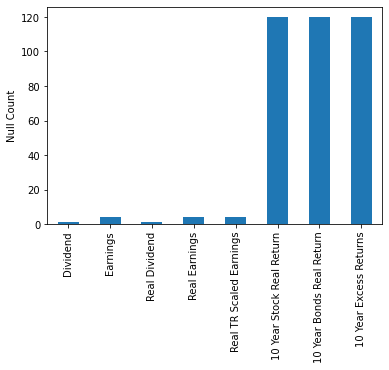

In [19]:
# Plot columns with the most null values

df.isnull().sum()[df.isnull().sum() > 0].plot(kind='bar', ylabel='Null Count')
plt.savefig('figures/null_count_by_column.png', bbox_inches='tight')
plt.show()

In [20]:
# Remove columns with most null values
print(df.isnull().sum())
df = df.drop(['10 Year Stock Real Return', 
              '10 Year Bonds Real Return',
              '10 Year Excess Returns'
             ], axis='columns')
print(df.isnull().sum())

DATE                            0
MSACSR                          0
MSPUS                           0
S&P Comp.                       0
Dividend                        1
Earnings                        4
CPI                             0
Long Interest Rate GS10         0
Real Price                      0
Real Dividend                   1
Real Total Return Price         0
Real Earnings                   4
Real TR Scaled Earnings         4
CAPE                            0
Total Return CAPE               0
Excess CAPE Yield               0
Monthly Total Bond Returns      0
Real Total Bond Returns         0
10 Year Stock Real Return     120
10 Year Bonds Real Return     120
10 Year Excess Returns        120
dtype: int64
DATE                          0
MSACSR                        0
MSPUS                         0
S&P Comp.                     0
Dividend                      1
Earnings                      4
CPI                           0
Long Interest Rate GS10       0
Real Price       

Index(['null_count'], dtype='object')


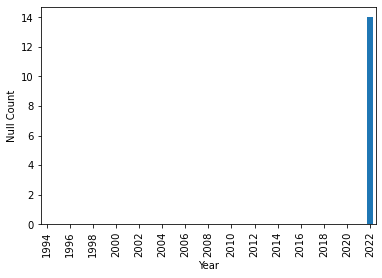

In [21]:
# Plot null count by year

temp_df['null_count'] = df.isnull().sum(axis='columns')
temp_df['Year'] = df['DATE'].dt.year
#temp_df['Month'] = df['DATE'].dt.month

nulls_by_year = temp_df[['null_count', 'Year']].groupby(by='Year').sum()
print(nulls_by_year.columns)
nulls_by_year_cut = nulls_by_year[31:]
#nulls_by_month = temp_df[['null_count', 'Month']].groupby(by='Month').sum()

#temp_df.plot(x = 'DATE', y = 'null_count')
fig = nulls_by_year_cut.plot.bar(legend=None)
fig.set_xticks(fig.get_xticks()[::2])
fig.set_ylabel('Null Count')

plt.savefig('figures/null_count_by_year.png')
plt.show()

In [22]:
print('Before:', df.shape)
df = df.dropna(axis='index')
print('After:', df.shape)

Before: (712, 18)
After: (708, 18)


In [23]:
df.head(12)

,DATE,MSACSR,MSPUS,S&P Comp.,Dividend,Earnings,CPI,Long Interest Rate GS10,Real Price,Real Dividend,Real Total Return Price,Real Earnings,Real TR Scaled Earnings,CAPE,Total Return CAPE,Excess CAPE Yield,Monthly Total Bond Returns,Real Total Bond Returns
0,1963-01-01,4.7,17800.000000,65.06,2.14,3.68,30.4,3.83,621.38,20.41,73576.49,35.18,4165.49,19.26,22.79,2.71,1.00,11.97
1,1963-02-01,6.6,18012.732655,65.92,2.14,3.70,30.4,3.92,629.59,20.47,74751.05,35.31,4191.90,19.47,23.03,2.60,1.00,11.92
2,1963-03-01,6.4,18054.359981,65.67,2.15,3.71,30.5,3.93,625.15,20.47,74425.91,35.32,4204.66,19.29,22.81,2.63,1.00,11.91
3,1963-04-01,5.3,18000.000000,68.76,2.17,3.75,30.5,3.97,654.56,20.63,78132.53,35.73,4264.94,20.15,23.82,2.37,1.01,11.91
4,1963-05-01,5.1,17912.319136,70.14,2.18,3.80,30.5,3.93,667.70,20.78,79907.38,36.14,4325.38,20.51,24.23,2.29,1.00,11.98
5,1963-06-01,6.0,17855.465475,70.11,2.20,3.84,30.6,3.99,665.23,20.87,79820.36,36.44,4371.85,20.38,24.08,2.25,1.00,11.93
6,1963-07-01,4.6,17900.000000,69.07,2.20,3.88,30.7,4.02,653.23,20.84,78588.54,36.70,4414.70,19.97,23.58,2.36,1.00,11.90
7,1963-08-01,5.6,18086.893729,70.98,2.21,3.92,30.7,4.00,671.29,20.87,80970.99,37.07,4471.77,20.47,24.16,2.21,1.00,11.96
8,1963-09-01,5.4,18328.158526,72.85,2.21,3.96,30.7,4.08,688.98,20.90,83314.29,37.45,4528.82,20.96,24.73,2.02,1.00,11.92
9,1963-10-01,5.9,18500.000000,73.03,2.23,3.98,30.8,4.11,688.44,21.05,83461.13,37.52,4548.48,20.89,24.63,2.00,1.00,11.89


### EDA

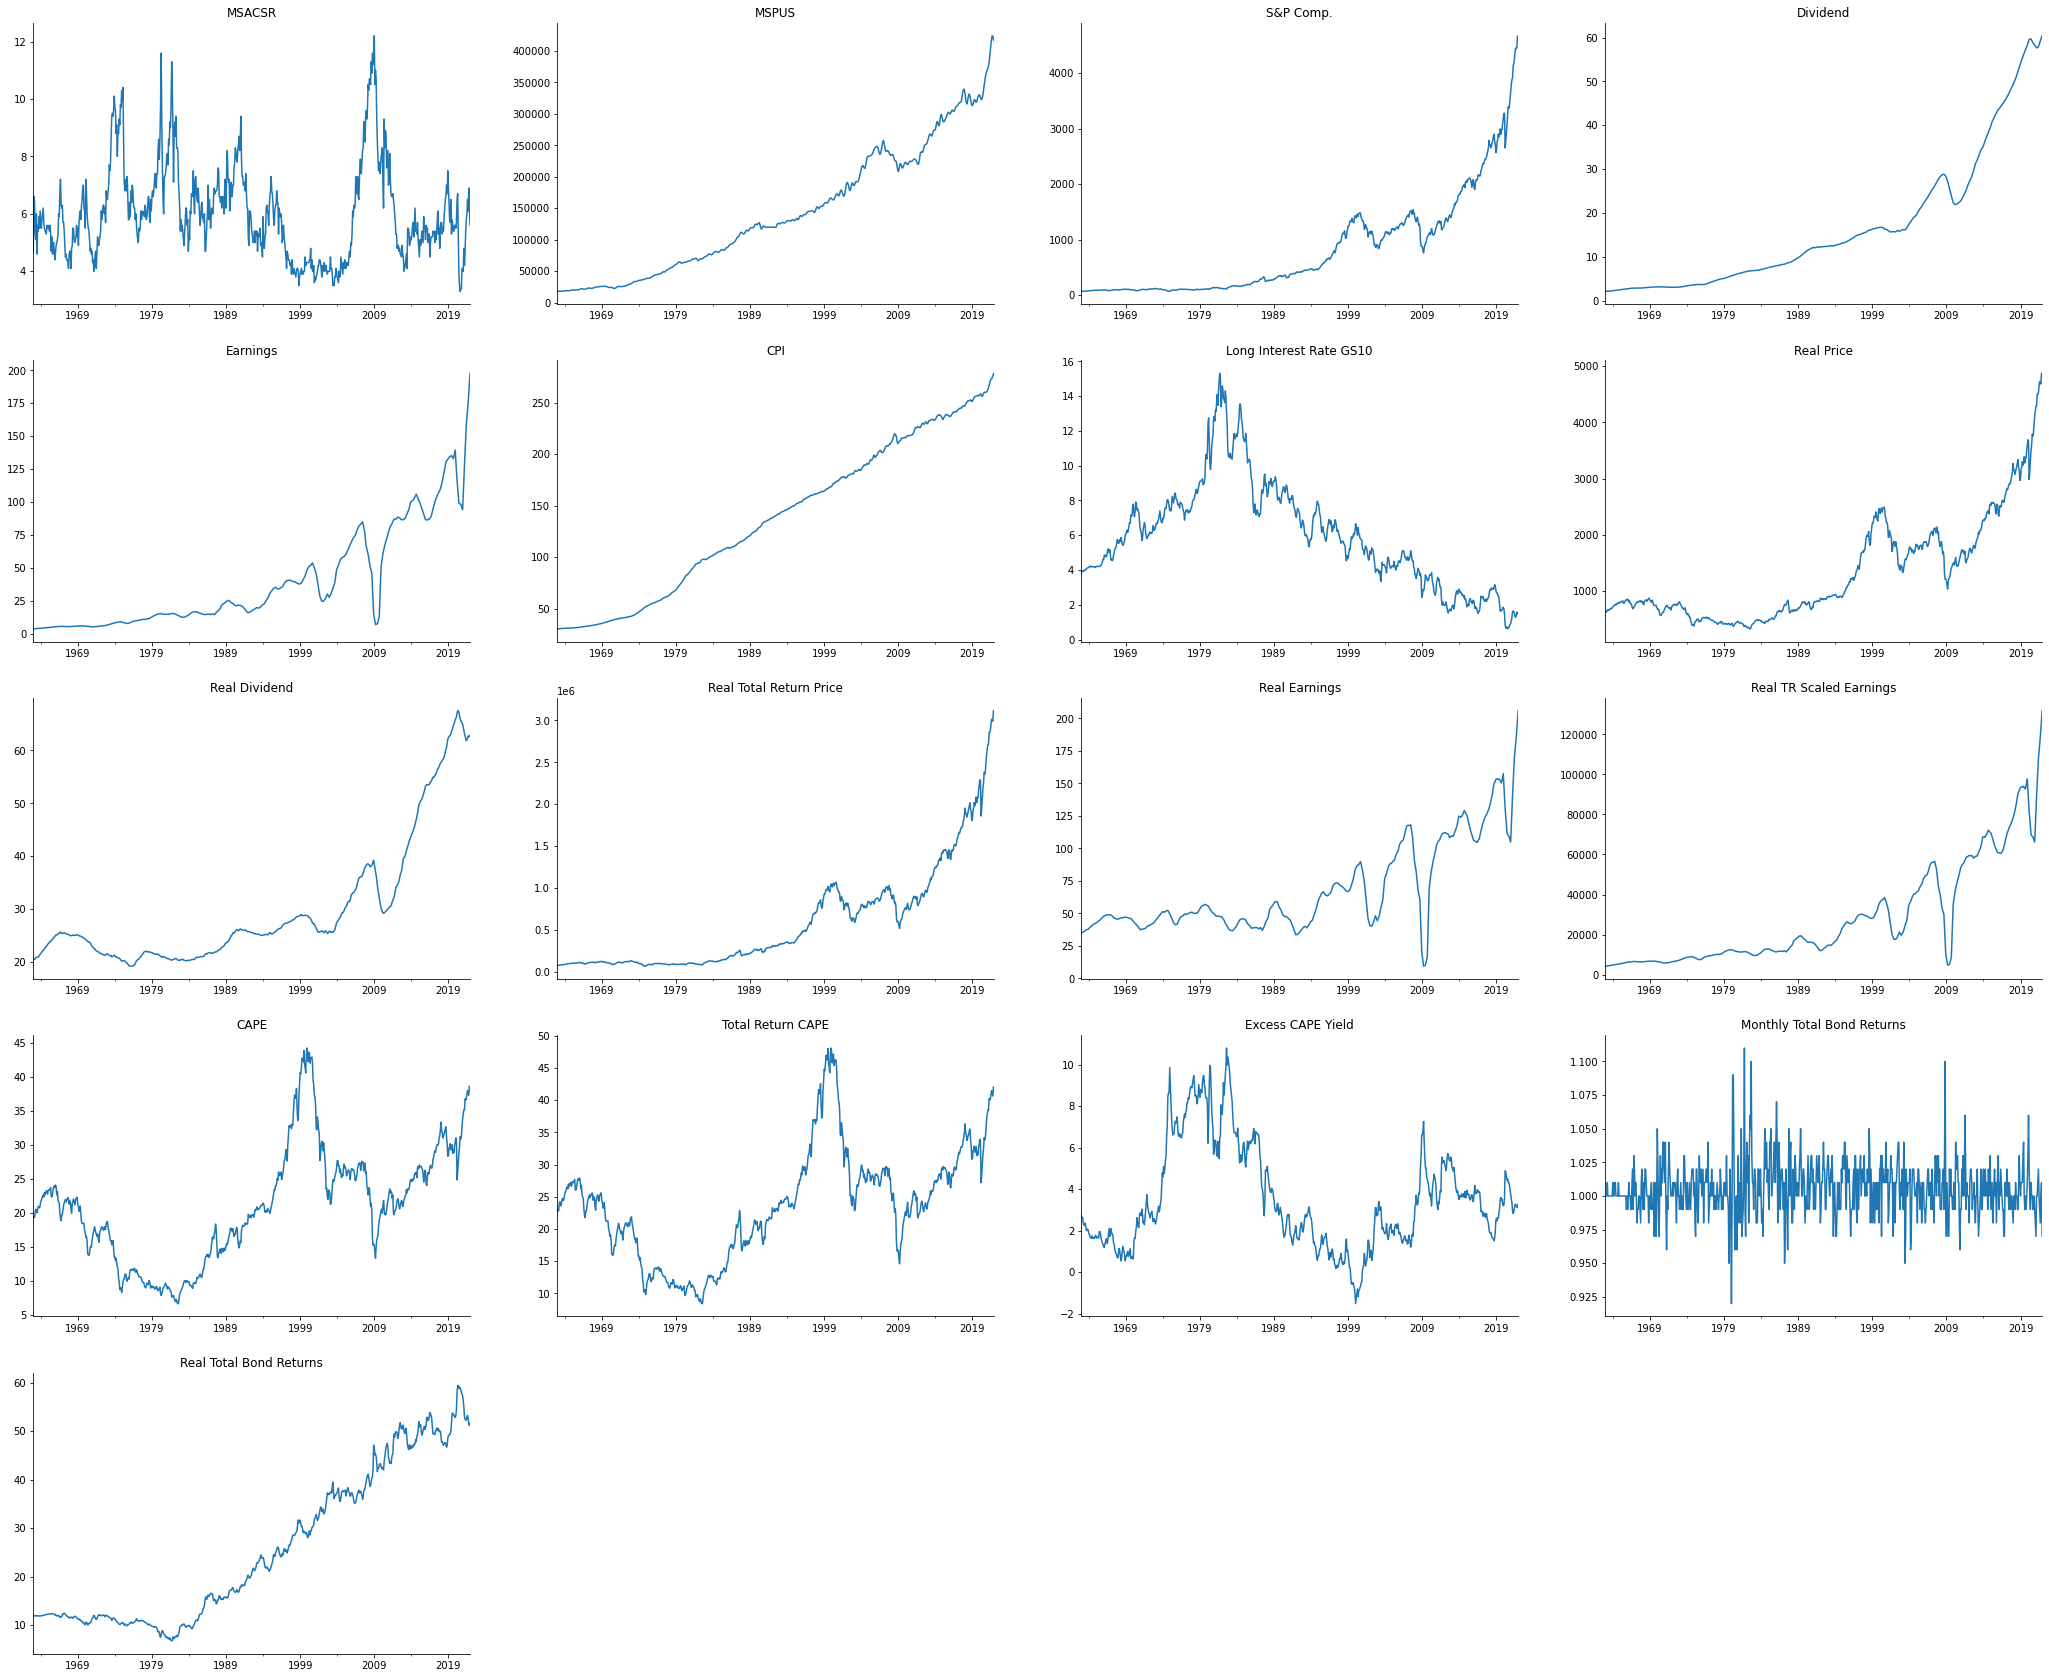

In [24]:
def plot_all_cols_line(df):
    plot_df = df.copy()

    fig, axes = plt.subplots(5, 4, figsize=(36, 30))
    for i, (name, col) in enumerate(plot_df.iteritems()):
        if name == 'DATE':  # Skip plotting dates
            continue
        i -= 1  # Shift all plots since skipping dates
        row_i = i // 4
        col_i = i % 4
        ax = axes[row_i, col_i] 
        ax2 = plot_df.plot.line(x='DATE', y=name, ax=ax, title=name, legend=False)
        # Remove some lines and labels for cleaner look
        ax2.set_xlabel('')
        for spine in ['top', 'right']:
            ax2.spines[spine].set_visible(False)

    # Delete empty plots
    fig.delaxes(axes[4][1])
    fig.delaxes(axes[4][2])
    fig.delaxes(axes[4][3])

plot_all_cols_line(df)
plt.savefig('figures/all_features_lineplot.png', bbox_inches='tight')
plt.show()

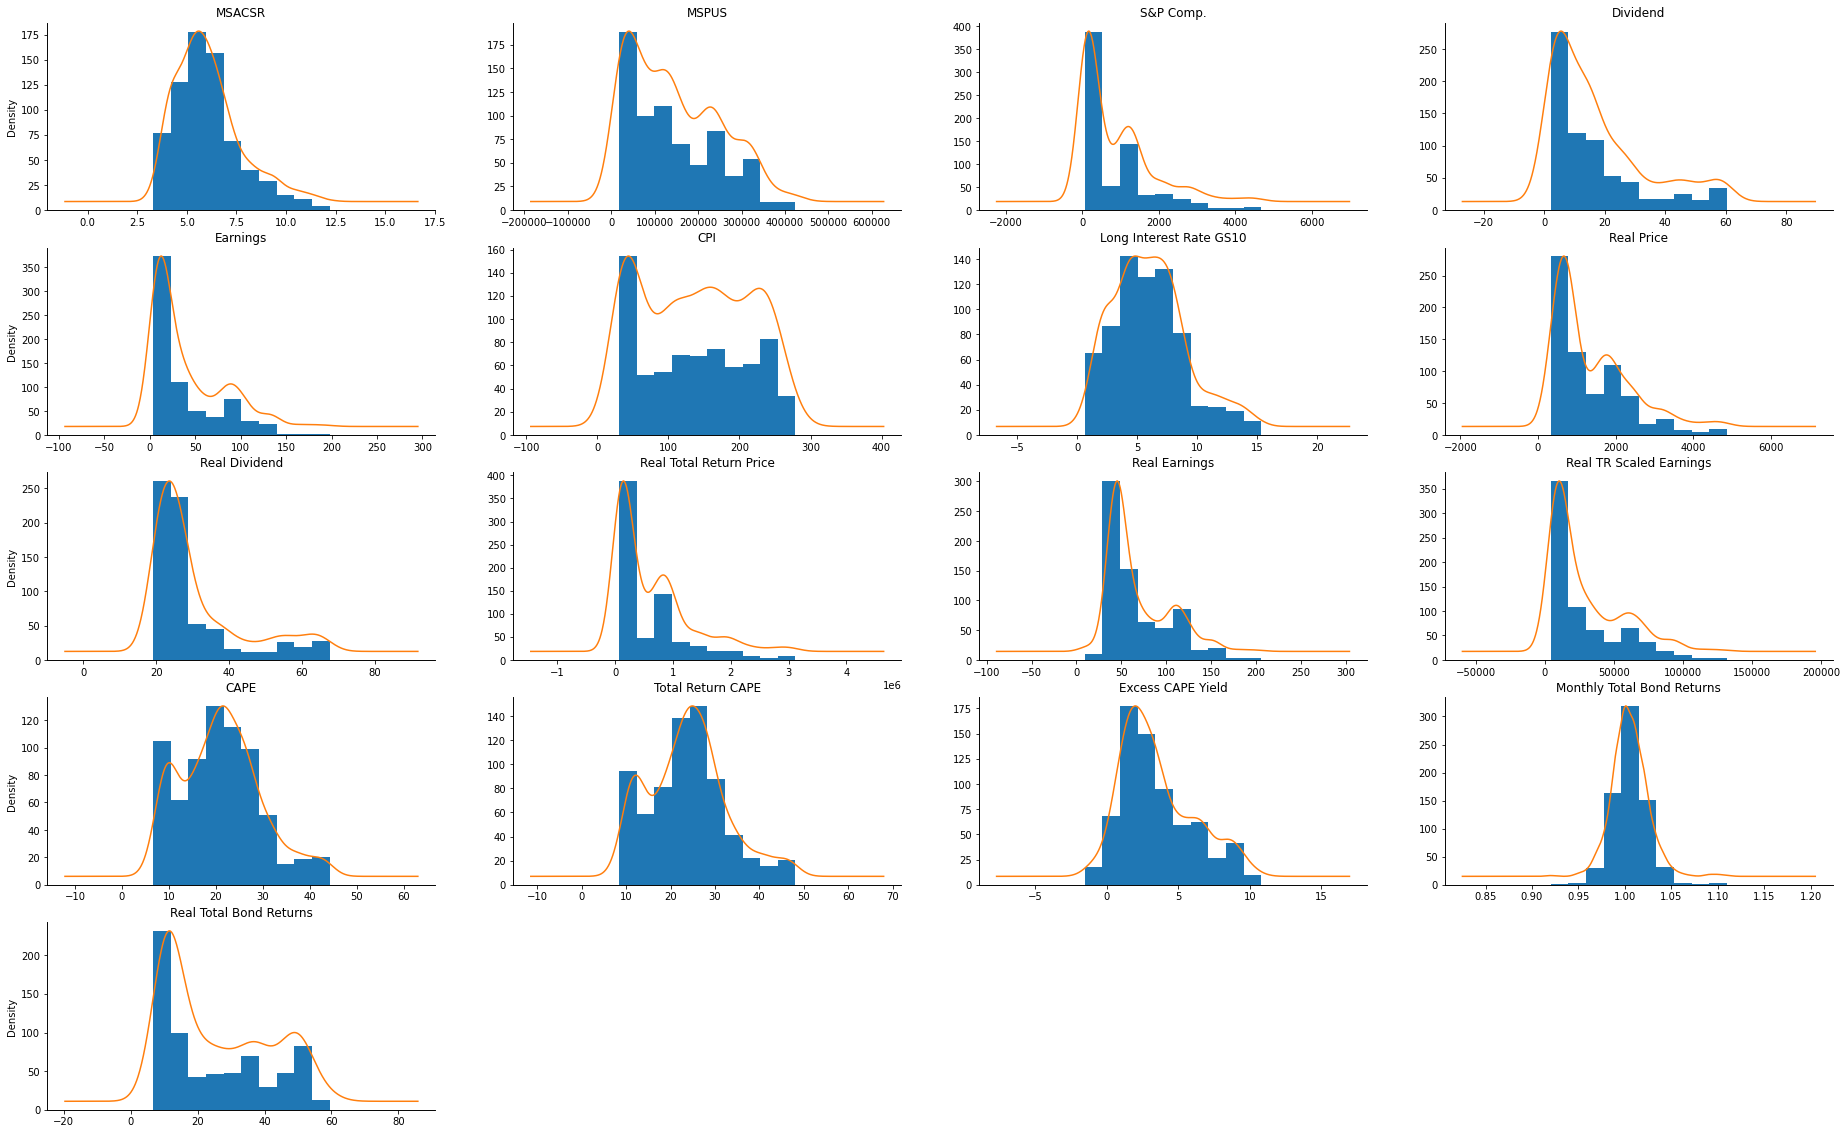

In [25]:
# Plot KDE Plots of all features before transforms

def plot_all_cols_kde(df):
    plot_df = df.copy()
    plot_df = plot_df.drop(['DATE'], axis='columns')

    fig, axes = plt.subplots(5, 4, figsize=(32, 20))
    for i, (name, col) in enumerate(plot_df.iteritems()):
        row_i = i // 4
        col_i = i % 4
        ax = axes[row_i, col_i] 
        col.hist(ax=ax)
        ax2 = col.plot.kde(ax=ax, secondary_y=True, title=name)
        # Remove some lines and labels for cleaner look
        if col_i != 0:  # Remove y label if not first in row for cleaner look
            ax.set_ylabel('')
            ax2.set_ylabel('')
        ax2.axes.get_xaxis().set_visible(False)
        ax2.axes.get_yaxis().set_visible(False)
        for axis in [ax, ax2]:
            for spine in ['top', 'right']:
                axis.spines[spine].set_visible(False)

    # Delete empty plots
    fig.delaxes(axes[4][1])
    fig.delaxes(axes[4][2])
    fig.delaxes(axes[4][3])

plot_all_cols_kde(df)
plt.savefig('figures/all_features_kdeplot.png', bbox_inches='tight')
plt.show()

In [26]:
# Log diff transform data

df_transformed = df.copy()
df_transformed.set_index('DATE')

for col in df_transformed.columns[1:]:  # Skip DATE column
    if col in ['Monthly Total Bond Returns',
               'Long Interest Rate GS10']:
        continue
    # Can't take log of negative values
    # Handle negative values with a mask
    mask = (df_transformed[col] < 0)
    
    df_transformed.loc[mask, col] = -np.log(-df_transformed[col][mask]).diff()
    df_transformed.loc[~mask, col] = np.log(df_transformed[col][~mask]).diff()

df_transformed = df_transformed.dropna()  # Drop first row NA's created by differencing
df_transformed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 706 entries, 1 to 707
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   DATE                        706 non-null    datetime64[ns]
 1   MSACSR                      706 non-null    float64       
 2   MSPUS                       706 non-null    float64       
 3   S&P Comp.                   706 non-null    float64       
 4   Dividend                    706 non-null    float64       
 5   Earnings                    706 non-null    float64       
 6   CPI                         706 non-null    float64       
 7   Long Interest Rate GS10     706 non-null    float64       
 8   Real Price                  706 non-null    float64       
 9   Real Dividend               706 non-null    float64       
 10  Real Total Return Price     706 non-null    float64       
 11  Real Earnings               706 non-null    float64       

In [27]:
# Diff long term interest rate
df_transformed['Long Interest Rate GS10'] = df_transformed['Long Interest Rate GS10'].diff()


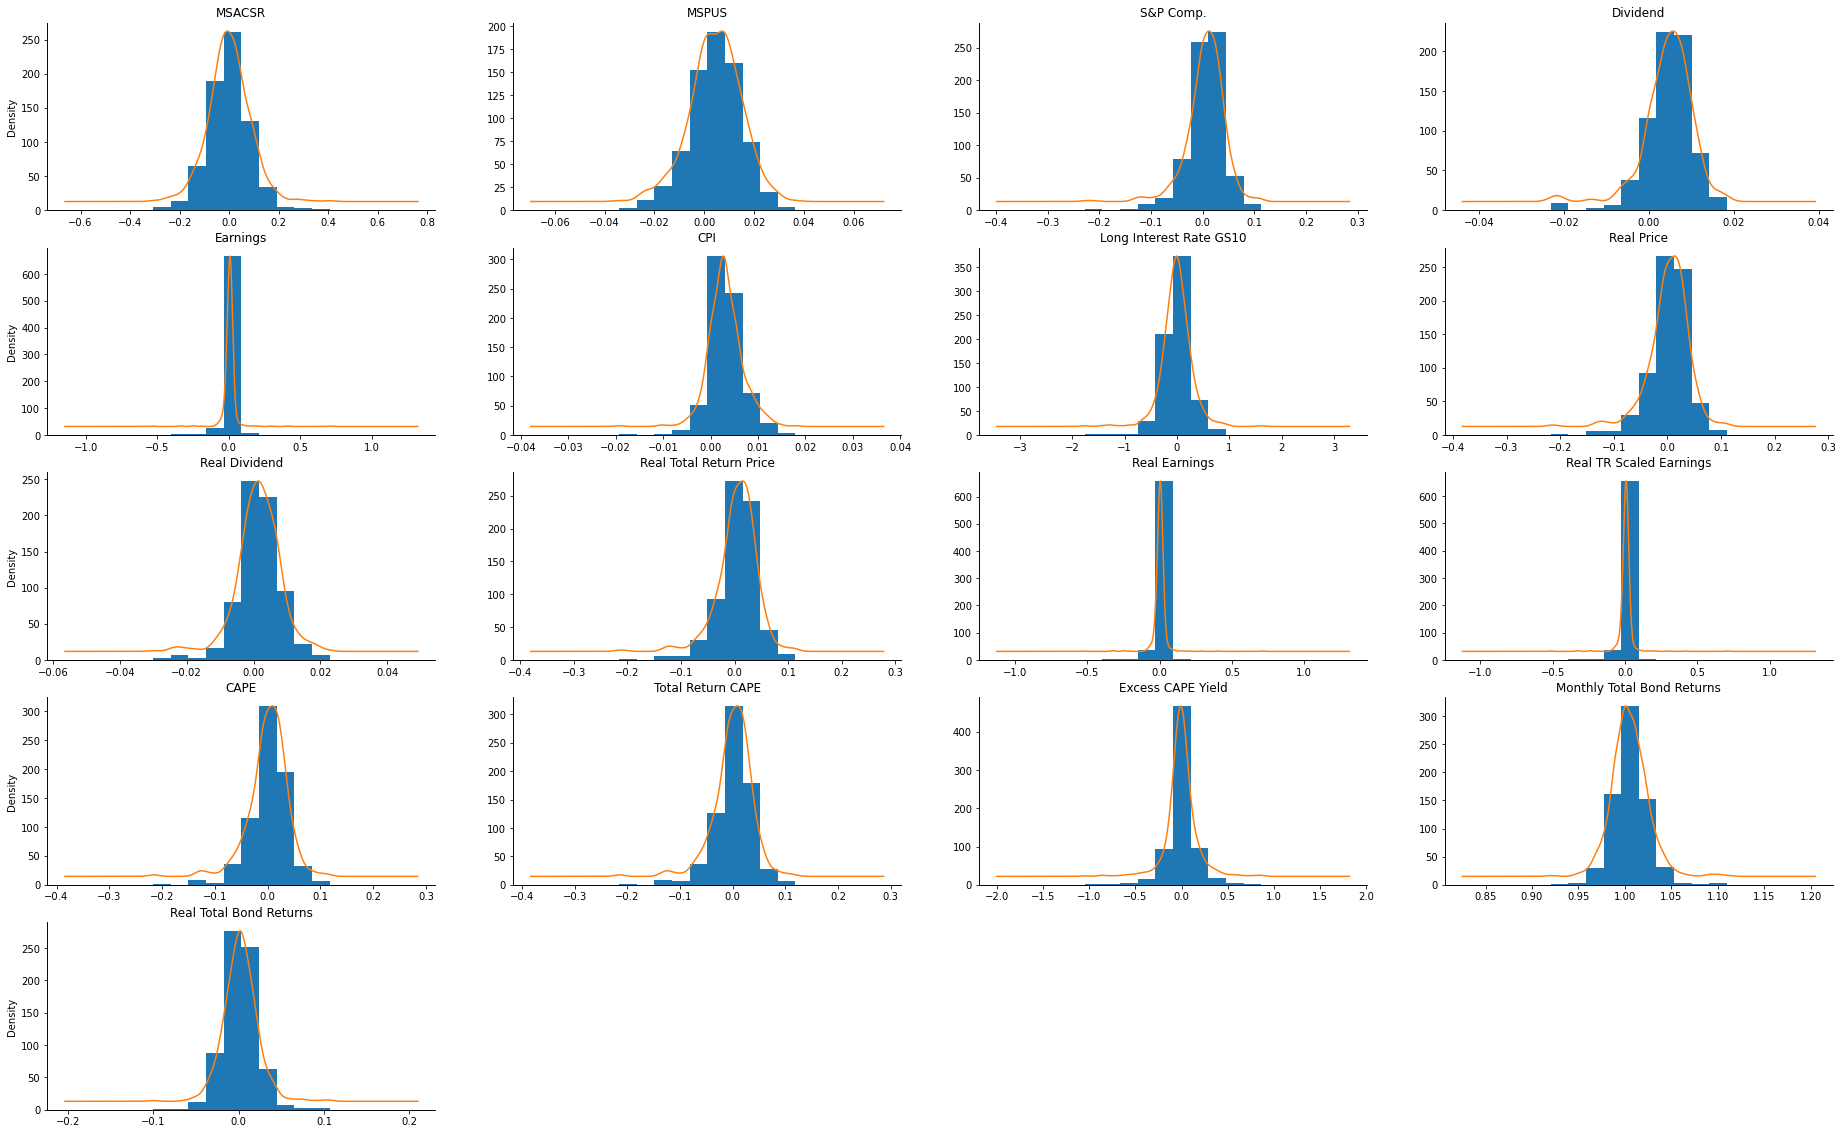

In [28]:
# Plot KDE Plots of all features AFTER transforms

plot_all_cols_kde(df_transformed)

plt.savefig('figures/all_trans_features_kdeplot.png', bbox_inches='tight')
plt.show()

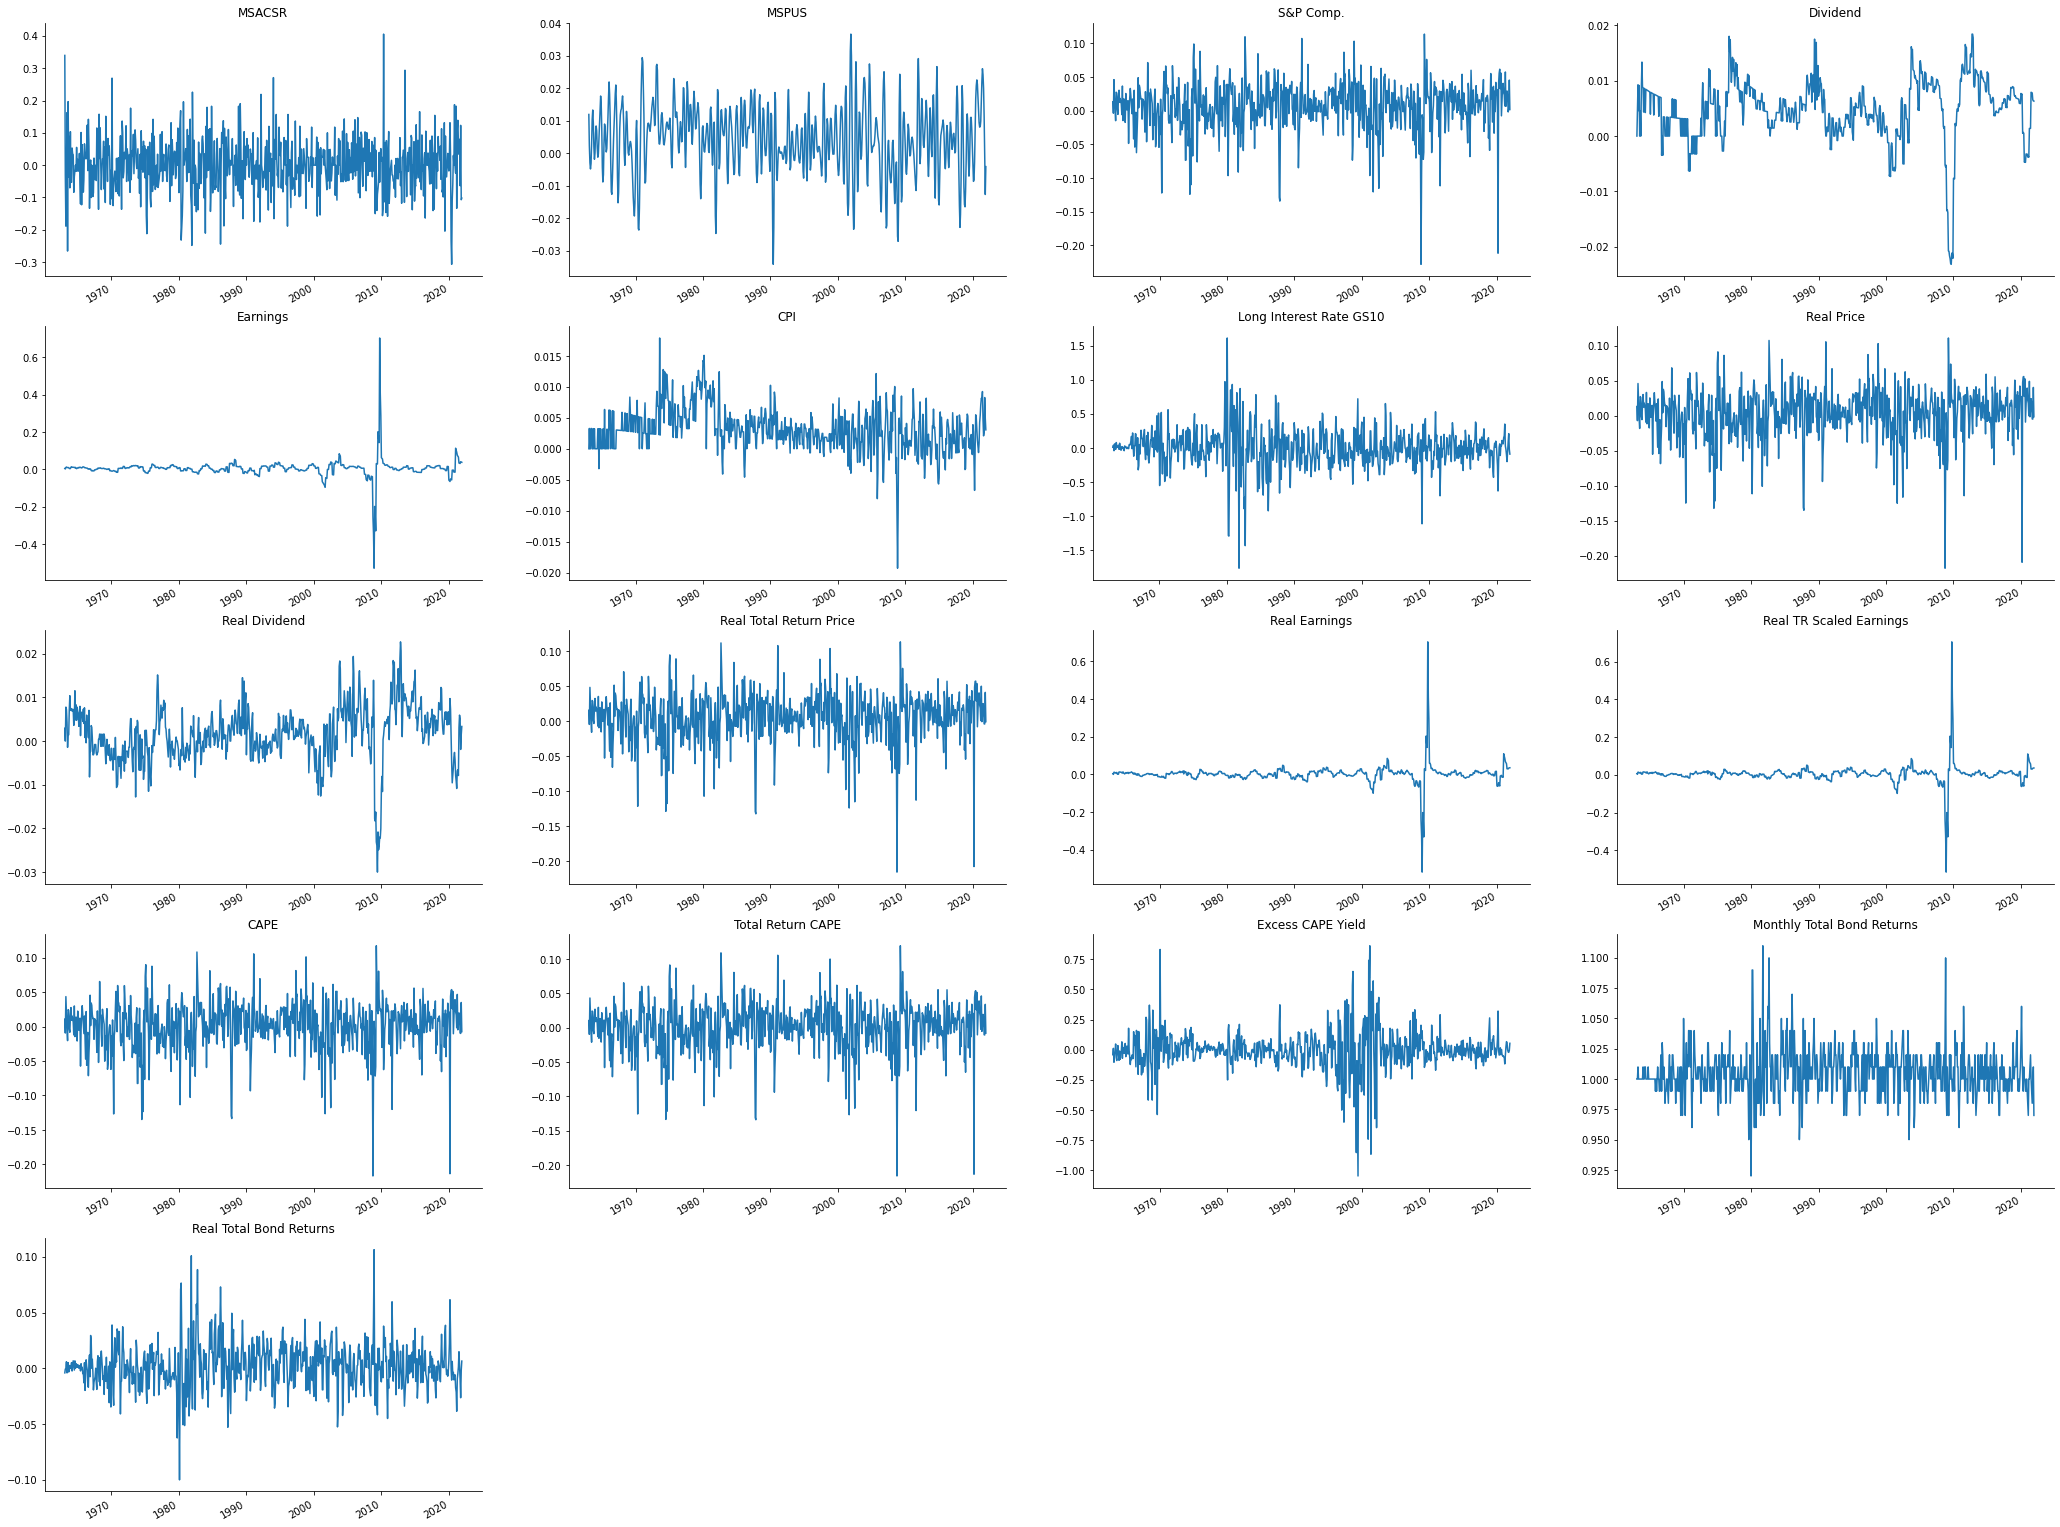

In [29]:
plot_all_cols_line(df_transformed)

plt.savefig('figures/all_trans_features_lineplot.png', bbox_inches='tight')
plt.show()

<AxesSubplot:>

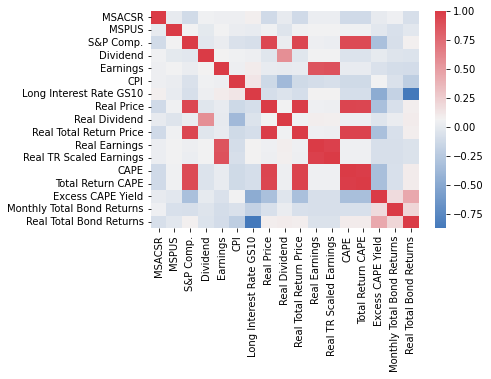

In [30]:
corr = df_transformed.corr(method='kendall')
cmap = sns.diverging_palette(250, 10, as_cmap=True)
heatmap = sns.heatmap(corr, cmap=cmap)

heatmap_fig = heatmap.get_figure()
heatmap_fig.savefig("figures/feature_corr_heatmap.png", bbox_inches='tight')
heatmap

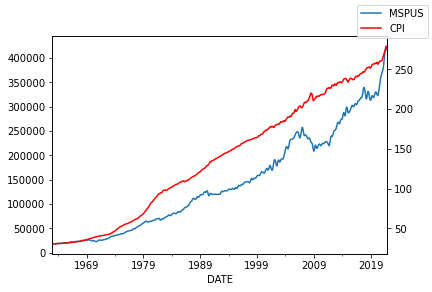

In [31]:
ax = df.plot(x='DATE', y='MSPUS', legend=False)
ax2 = ax.twinx()
df.plot(x='DATE', y='CPI', ax=ax2, legend=False, color='r')
ax.figure.legend()
plt.show()

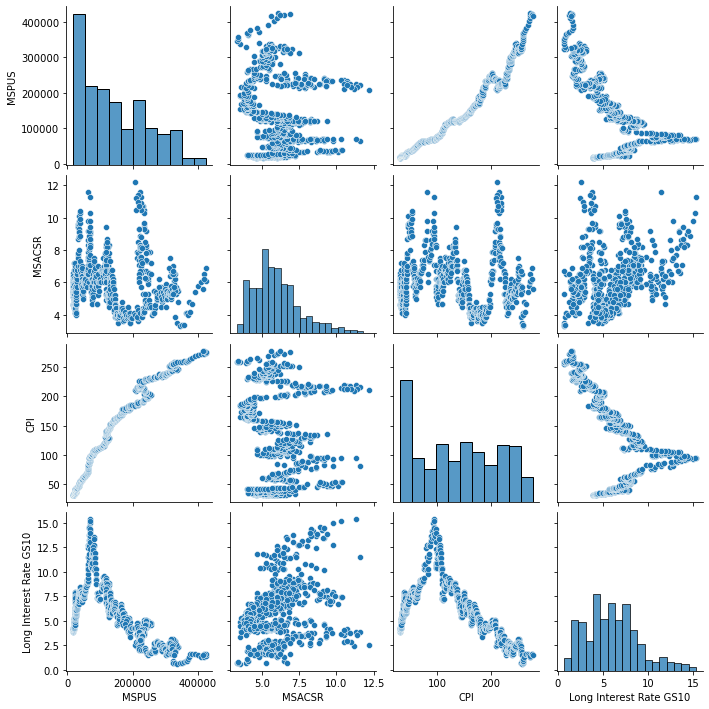

In [32]:
pairplot = sns.pairplot(df[['MSPUS', 'MSACSR', 'CPI', 'Long Interest Rate GS10']])

pairplot.savefig("figures/pairplot.png", bbox_inches='tight')
pairplot

In [33]:
# Test for stationerity

If data shows a strong trend or seasonality, it is not stationary.

Price data is not stationary

Differencing is one way to make stationary for classical models

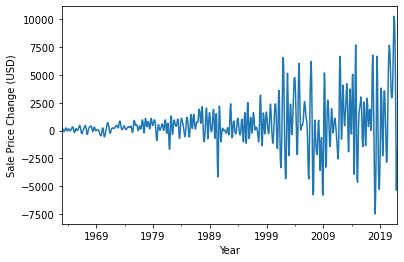

In [34]:
temp_df = df.copy()
temp_df['Price Difference'] = df['MSPUS'].diff().dropna()

temp_df.plot.line('DATE', 'Price Difference',
                  xlabel='Year',
                  ylabel='Sale Price Change (USD)',
                  legend=False
                 )

plt.savefig('figures/price_1st_difference.png', bbox_inches='tight')
plt.show()

After running the difference between each successive entry in the price series, we can see that the variance increases as time goes on. 

1       212.732655
2        41.627326
3       -54.359981
4       -87.680864
5       -56.853661
          ...     
703    8257.995003
704    4670.355690
705    -528.350693
706   -5360.346415
707   -1741.814761
Name: Price Difference, Length: 707, dtype: float64
507 200
Iteration:      1,   Func. Count:     23,   Neg. LLF: 2139.6500316849483
Iteration:      2,   Func. Count:     46,   Neg. LLF: 24622.760164888212
Iteration:      3,   Func. Count:     69,   Neg. LLF: 1883.3361539382868
Iteration:      4,   Func. Count:     92,   Neg. LLF: 1734.6544603835384
Iteration:      5,   Func. Count:    114,   Neg. LLF: 1730.6112531484332
Iteration:      6,   Func. Count:    136,   Neg. LLF: 1770.0716910626418
Iteration:      7,   Func. Count:    159,   Neg. LLF: 1731.3440820084165
Iteration:      8,   Func. Count:    182,   Neg. LLF: 1738.5525736298105
Iteration:      9,   Func. Count:    205,   Neg. LLF: 1719.8137722267875
Iteration:     10,   Func. Count:    227,   Neg. LLF: 1720.936888186299
It

/home/harrison/anaconda3/envs/mas-thesis/lib/python3.10/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


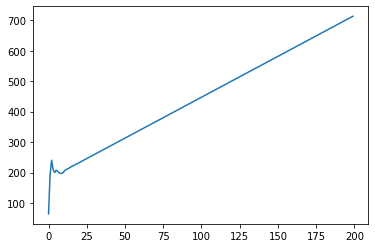

In [35]:
# Try a simple GARCH model
# Autoregressivice Conditional Heteroskedasticity
# Used to predict volatility

price_diff = temp_df['Price Difference'].dropna()
print(price_diff)

# Zero mean for model
price_diff = price_diff - price_diff.mean()

TEST_SIZE = 200
train, test = price_diff[:-TEST_SIZE], price_diff[-TEST_SIZE:]
print(len(train), len(test))

# TODO: experiment with p, q values (lag order of symmetric innovation, lagged volatility respectively) 
# AIC is recommended for forecasting, BIC for explanatory modeling
# Used p,q=10 because that is where we see significant autocorrelation
model = arch_model(train, mean='Zero', vol='GARCH', p=10, q=10, rescale=True)  # Auto rescale values for optimizer
fitted = model.fit()

yhat = fitted.forecast(horizon=TEST_SIZE)
plt.plot(yhat.variance.values[-1, :])
plt.show()

In [43]:
# TODO: Pair GARCH with ARIMA to get simple predictions

print(df_transformed.columns)

arima_model = pmdarima.auto_arima(df_transformed['MSPUS'], start_p=0, start_q=0,
                            test='adf',
                            max_p=4, max_q=4,
                            m=1,
                            d=None,
                            seasonal=False,
                            start_P=0,
                            D=0,
                            trace=True,
                            stepwise=True
                           )

print(arima_model.summary())

Index(['DATE', 'MSACSR', 'MSPUS', 'S&P Comp.', 'Dividend', 'Earnings', 'CPI',
       'Long Interest Rate GS10', 'Real Price', 'Real Dividend',
       'Real Total Return Price', 'Real Earnings', 'Real TR Scaled Earnings',
       'CAPE', 'Total Return CAPE', 'Excess CAPE Yield',
       'Monthly Total Bond Returns', 'Real Total Bond Returns'],
      dtype='object')
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-4335.463, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-5079.144, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-5087.483, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-5585.169, Time=0.25 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-5973.712, Time=0.39 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-5776.576, Time=0.11 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-6137.961, Time=0.58 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-6185.978, Time=0.10 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=-6188.979, Tim

<AxesSubplot:>

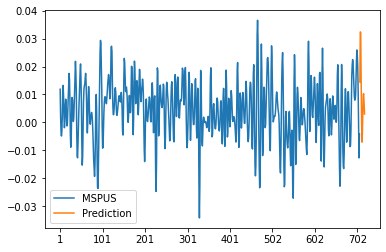

In [84]:
N_PRED = 12

#print(df_transformed['DATE'])
new_index = df_transformed.iloc[-N_PRED:, :]['DATE']

# Get ARIMA predictions
forecast, conf_int = arima_model.predict(n_periods=N_PRED, return_conf_int=True)

# Put predictions into df
forecast_df = pd.DataFrame(forecast, 
                           index=new_index,
                           columns=['Prediction']
                          )

pd.concat( [df_transformed['MSPUS'], forecast_df], axis=1 ).plot()

In [93]:
# Convert back to price values

def inverse_pct_change(series, y_0):
    np_series = np.array(series)  # Use np array for built in cumsum
    np_series[0] = np.log(y_0)
    cumulative_sum = np_series.cumsum()
    
    return np.exp(cumulative_sum)

initial_value_pred = df.iloc[-N_PRED]['MSPUS']

print('y_0_pred', initial_value_pred)

# Convert predictions to price values
forecast_df['Pred_Price'] = inverse_pct_change(forecast_df['Prediction'], initial_value_pred)

# Convert confidence interval to price values
forecast_df['conf_lower'] = inverse_pct_change(conf_int[:, 0], initial_value_pred)
forecast_df['conf_upper'] = inverse_pct_change(conf_int[:, 1], initial_value_pred)

forecast_df.head()

y_0_pred 369800.0


,Prediction,Pred_Price,conf_lower,conf_upper
DATE,,,,
2021-01-01,0.014467,369800.000000,369800.000000,369800.000000
2021-02-01,0.032435,381991.179115,377793.916271,386235.073243
2021-03-01,0.032220,394499.325343,383690.587665,405612.550059
2021-04-01,0.017020,401271.335483,382910.941013,420512.101990
2021-05-01,0.000342,401408.701905,375756.419814,428812.223740


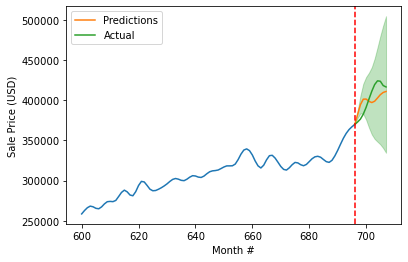

In [94]:
# Plot results in price
def plot_actual_vs_pred(test_predictions, test_actual, y, conf_lower, conf_upper, plot_savename):
    N = len(y)
    CUTOFF = 600  # 200 for quarterly data
    
    actual_slice_end = N - N_PRED + 1
    
    actual_slice = [i for i in range(CUTOFF, actual_slice_end)]
    pred_slice = [i for i in range(N - N_PRED, N)]
    plt.plot(actual_slice, y[CUTOFF:actual_slice_end])
    plt.fill_between(pred_slice, conf_lower, conf_upper, alpha=0.3, color='C2')
    plt.plot(pred_slice, test_predictions, label='Predictions')
    plt.plot(pred_slice, test_actual, label='Actual')
    plt.axvline(x=len(y)-N_PRED, c='red', linestyle='--')


    plt.legend()
    plt.xlabel('Month #')
    plt.ylabel('Sale Price (USD)')
    plt.savefig(plot_savename, bbox_inches='tight')
    plt.show()
    

test_actual = df.iloc[-N_PRED:]['MSPUS']

plot_name = 'figures/arima_scale_actual_vs_pred.png'
plot_actual_vs_pred(forecast_df['Pred_Price'], 
                    test_actual, 
                    df['MSPUS'], 
                    forecast_df['conf_lower'], forecast_df['conf_upper'], 
                    plot_name
                   )

In [ ]:
# Try with log diff (can also be thought of as log returns)

# Math note: log(P[t] / P[t-1]) = logP[t] - logP[t-1]
log_diff = np.log( df['MSPUS'] / df['MSPUS'].shift(1) ).dropna()
df['logdiff_MSPUS'] = log_diff

df.plot.line('DATE', 'logdiff_MSPUS',
             ylabel='Log Returns',
             xlabel='Year',
             legend=False
            )

plt.savefig('figures/logdiff_MSPUS.png')
plt.show()

In [ ]:
auto_corr = sm.graphics.tsa.plot_acf(log_diff)

auto_corr.savefig("figures/autocorrelation_mspus_tr.png", bbox_inches='tight')
auto_corr

### Save Processed Data

In [ ]:
# Pickle saves exact dataframe for python to load later
df.to_pickle('data/processed.pkl')

# Save to csv for Rstudio
df.to_csv('data/processed.csv')